In [1]:
import os
from EMsoft import pyEMsoft
from EMsoft import pyEMsoftTools
import numpy as np
import h5py as h5
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import subprocess

In [2]:
# path to the experimental data file
path = '/home/chaoyi/EMsoftGeneratedData/EDAX-Ni.h5'

# path for the output data, temporary Euler angle file, and master pattern
emdatapath = '/home/chaoyi/EMsoftGeneratedData'

# preview the data structure
with h5.File(path,'r') as hf:
    hf.visit(print)

 Manufacturer
 Version
Scan 1
Scan 1/EBSD
Scan 1/EBSD/Data
Scan 1/EBSD/Data/CI
Scan 1/EBSD/Data/Fit
Scan 1/EBSD/Data/IQ
Scan 1/EBSD/Data/PRIAS Bottom Strip
Scan 1/EBSD/Data/PRIAS Center Square
Scan 1/EBSD/Data/PRIAS Top Strip
Scan 1/EBSD/Data/Pattern
Scan 1/EBSD/Data/Phase
Scan 1/EBSD/Data/Phi
Scan 1/EBSD/Data/Phi1
Scan 1/EBSD/Data/Phi2
Scan 1/EBSD/Data/SEM Signal
Scan 1/EBSD/Data/Valid
Scan 1/EBSD/Data/X Position
Scan 1/EBSD/Data/Y Position
Scan 1/EBSD/Header
Scan 1/EBSD/Header/Camera Azimuthal Angle
Scan 1/EBSD/Header/Camera Elevation Angle
Scan 1/EBSD/Header/Coordinate System
Scan 1/EBSD/Header/Coordinate System/EBSD View Reference Frame
Scan 1/EBSD/Header/Coordinate System/ID
Scan 1/EBSD/Header/Coordinate System/Schematic 1
Scan 1/EBSD/Header/Coordinate System/Schematic 2
Scan 1/EBSD/Header/Coordinate System/Schematic 3
Scan 1/EBSD/Header/Coordinate System/Schematic 4
Scan 1/EBSD/Header/Grid Type
Scan 1/EBSD/Header/Notes
Scan 1/EBSD/Header/Operator
Scan 1/EBSD/Header/Pattern Center

In [3]:
# which scan data to look at (name of the data set)
data_set = 'Scan 1'
# input experimental data type ('TSLHDF' or 'BrukerHDF')
inputtype='TSLHDF'
# load the experimental data set
EBSD, Pattern, Angles = pyEMsoftTools.loadPattern(inputtype, data_set, path)
# pattern quality map and scan coordinates
PatternQuality, SEM = pyEMsoftTools.loadSEM(Pattern.inputtype, data_set, path)


In [4]:
# Selection of the diffraction pattern to be optimized
@interact(scan_x=widgets.IntSlider(min=0, max=Pattern.ipf_wd-1, step=1, value=0), scan_y=widgets.IntSlider(min=0, max=Pattern.ipf_ht-1, step=1, value=0))

def g(scan_x, scan_y):
    Pattern.patx = scan_x
    Pattern.paty = scan_y

    ExperimentalPattern = pyEMsoftTools.getSingleEBSDPattern(
    data_set, EBSD, Pattern, path)

    plt.subplot(1,2,1)
    plt.imshow(PatternQuality,cmap='gray')
    plt.scatter(scan_x,scan_y,s=15, marker='x', c='r')
    plt.xlim(0, Pattern.ipf_wd)
    plt.ylim(Pattern.ipf_ht, 0)

    plt.subplot(1,2,2)
    plt.imshow(ExperimentalPattern, cmap="gray")
    plt.title('Experimental Pattern')
    plt.axis('off')
    plt.show()

interactive(children=(IntSlider(value=0, description='scan_x', max=185), IntSlider(value=0, description='scan_…

In [5]:
# range of the kV to use (in the master pattern)
EBSD.energymax = 20
EBSD.energymin = 10
EBSD.masterfile = 'Ni-master-20kV.h5'  # relative to EMdatapathname
# EBSD.masterfile = 'Ferrite_master_20kV.h5'
EBSD.includebackground = 'n'
# intensity scaling mode 'not' = no scaling, 'lin' = linear, 'gam' = gamma correction
EBSD.scalingmode = 'gam'
# gamma correction factor
EBSD.gammavalue = 0.33
# Get the correpsonding experimental pattern at beam position (patx,paty)
ExperimentalPattern = pyEMsoftTools.getSingleEBSDPattern(
    data_set, EBSD, Pattern, path)
# convert it to grayscale [0,255]
ExperimentalPattern = pyEMsoftTools.getGrayscale(ExperimentalPattern)

In [6]:
# Selection of the adaptive histogram equalization parameter (mask: optional)
def f(mask, nregions):

    Filtered_Exp = pyEMsoft.Filters.adhisteq(nregions, EBSD.numsy, EBSD.numsx, ExperimentalPattern)
    EBSD.maskpattern='n'
    if mask==True:
        mask=pyEMsoftTools.circular_mask(EBSD.numsy,EBSD.numsx)
        Filtered_Exp = np.multiply(mask,Filtered_Exp)
        EBSD.maskpattern='y'


    EBSD.nregions=nregions
    plt.subplot(2,2,1)
    plt.imshow(ExperimentalPattern, cmap="gray")
    plt.title('Experimental Pattern')
    plt.axis('off')

    plt.subplot(2,2,2)
    plt.imshow(Filtered_Exp, cmap="gray")
    plt.title('Filtered Experimental Pattern')
    plt.axis('off')

    plt.subplot(2,2,(3,4))
    plt.hist(ExperimentalPattern.flatten(), bins=180, label='Experimental')
    plt.hist(Filtered_Exp[np.nonzero(Filtered_Exp)], bins=180, label='Filtered Experimental')
    plt.legend(loc='upper right')
    plt.ylabel('Counts')
    plt.show()
    

interact(f, mask=True, nregions=widgets.IntSlider(min=1, max=15, step=1, value=10))

interactive(children=(Checkbox(value=True, description='mask'), IntSlider(value=10, description='nregions', ma…

<function __main__.f(mask, nregions)>

In [7]:
# if this is 'n' no mask and adaptive histogram equalization will be used for experimental pattern
EBSD.makedictionary = 'y'

# binning is optional but will speed up optimization (not recommended for deformation inference)
EBSD.binning = 1

# Convert the Euler angles to a testeuler.txt file relative to EMdatapathname
pyEMsoftTools.createAngleFile(emdatapath, 'eu', Pattern, Angles)

# generate template file for EMEBSD and update the namelist
pyEMsoftTools.EMEBSDnamelistUpdate(EBSD)
os.system('EMEBSD EMEBSD.nml')

# read simulated pattern from EMEBSD output data
SimulatedPattern = pyEMsoftTools.getSingleEBSDPattern(
    'EMData', EBSD, Pattern, emdatapath)

# pattern center before optimization
xpc = EBSD.xpc
ypc = EBSD.ypc
L = EBSD.L

# orientation before optimization
quaternion = Angles[:, Pattern.paty*Pattern.ipf_wd+Pattern.patx]

In [8]:
# a Namelist class containing optimization parameters
Opt = pyEMsoft.Namelisttypedefs.EBSDDENameListType
# Deformation tensor inference (if 'y', the orientation optimization will be swithced off)
EBSD.applyDeformation = 'n'
# bounds for variables to be optimized
# [deformation tensor, mis [degree], normalized PC [% detector width]]
Opt.bound = [0.001, 2, 2]
# maximum number of iterations [50,100]
Opt.itermax = 50
# refresh frequency
Opt.refresh = 10
# population size (10*number of variables)
Opt.NP = 60
# Nelder-Mead simplex refinement after the global optimization  (optional)
Opt.hybrid='n'
# number of threads ued for optimization (openmp)
EBSD.nthreads = 4
# file name of the optimization output data
EBSD.datafile='global optimization data.h5'
# generate template file for EMEBSDGlobalOpt and update the namelist
pyEMsoftTools.EMEBSDGlobalOptimizationUpdate(data_set, Opt, EBSD, Pattern)
# print the optimization results 
output = subprocess.check_output(['EMEBSDGlobalOpt', 'EMEBSDGlobalOpt.nml'])
output = output.decode("utf-8")
print(output)



 Copyright (C) 2001-2019 Marc De Graef Research Group/CMU
 EMsoft comes with ABSOLUTELY NO WARRANTY.
 This is free software, and you are welcome to redistribute it
 under certain conditions; see License.txt file for details.


 Program name         : EMEBSDGlobalOpt.f90
 Purpose              : Global Optimization for Pattern Center, Orientation, and Deformation using Dynamical EBSD patterns
 Platform             : Linux
 Source code version  : 5_0_20201129_be3b01a
 Source code Revision : be3b01a
 Build Date/Time      : 2020-11-30 02:05:50Z

 See https://github.com/EMsoft-org/EMsoft/wiki for selected help pages.

 Dec 12 2020  11:25:11.827 PM


Number of command line arguments detected:           1
Pattern input file /home/chaoyi/EMsoftGeneratedData/EDAX-Ni.h5
  input file type TSLHDF
Euler angle convention: tsl
 Converting Euler angles to quaternions
 Number of orientations imported:       28086
 Tilt angle of the camera:   10.0000000    
 Camera Azimuthal Angle:   0.00000000    
Pat

In [9]:

EBSD_Opt, Angles_Opt, Ftensor = pyEMsoftTools.loadOptimizationData(
    emdatapath, Pattern.inputtype, EBSD, Opt)

# pattern center after optimization
xpc_opt = EBSD_Opt.xpc
ypc_opt = EBSD_Opt.ypc
L_opt = EBSD_Opt.L

pyEMsoftTools.createAngleFile(emdatapath, 'eu', Pattern, Angles_Opt)

pyEMsoftTools.EMEBSDnamelistUpdate(EBSD_Opt)

os.system('EMEBSD EMEBSD.nml')
SimulatedPattern_Opt = pyEMsoftTools.getSingleEBSDPattern(
    'EMData', EBSD_Opt, Pattern, emdatapath)

print('Before Optimization: xpc=%.2f, ypc=%.2f,L=%.2f' % (xpc, ypc, L))
print('After Optimization: xpc=%.2f, ypc=%.2f,L=%.2f' % (xpc_opt, ypc_opt, L_opt))




Before Optimization: xpc=-0.44, ypc=14.28,L=1983.75
After Optimization: xpc=-1.14, ypc=13.74,L=1993.79


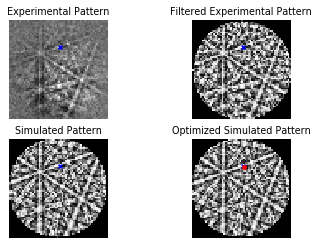

In [10]:
Filtered_Exp = pyEMsoft.Filters.adhisteq(
   EBSD.nregions, EBSD.numsy, EBSD.numsx, ExperimentalPattern)

if EBSD.maskpattern=='y':
    mask=pyEMsoftTools.circular_mask(EBSD.numsy,EBSD.numsx)
    Filtered_Exp = np.multiply(mask,Filtered_Exp)

plt.rcParams['font.size'] = 8

fig = plt.figure()
plt.subplot(2, 2, 1)
plt.imshow(ExperimentalPattern, cmap="gray")
plt.scatter(EBSD.numsx/2.0-xpc, EBSD.numsy /
            2.0-ypc, s=15, marker='x', c='b')
plt.title('Experimental Pattern')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(Filtered_Exp, cmap="gray")
plt.scatter(EBSD.numsx/2.0-xpc, EBSD.numsy /
            2.0-ypc, s=15, marker='x', c='b')
plt.title('Filtered Experimental Pattern')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(SimulatedPattern, cmap="gray")
plt.scatter(EBSD.numsx/2.0-xpc, EBSD.numsy /
            2.0-ypc, s=15, marker='x', c='b')
plt.title('Simulated Pattern')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(SimulatedPattern_Opt, cmap="gray")
plt.scatter(EBSD.numsx/2.0-xpc, EBSD.numsy /
            2.0-ypc, s=15, marker='x', c='b')
plt.scatter(EBSD.numsx/2.0-xpc_opt, EBSD.numsy /
            2.0-ypc_opt, s=15, marker='o', c='r')
plt.title('Optimized Simulated Pattern')
plt.axis('off')
plt.show()

In [11]:
dict=pyEMsoft.typedefs.dicttype()
# indicate rotational point group
dict.pgnum=32
pyEMsoft.Dictmod.di_init(dict,'sym')
eu1=pyEMsoft.rotations.qu2eu(quaternion)
eu2=pyEMsoft.rotations.qu2eu(Angles_Opt)

ax=np.asarray(np.zeros(3), dtype=np.float64, order='F')
disang=pyEMsoft.Dictmod.getdisorientationangle(eu1,eu2,dict,ax)

print('Before Optimization: q1='+str(quaternion.round(3)))
print('After Optimization: q2='+str(Angles_Opt.round(3)))
print('Disorientation between q1 and q2 = '+str(round(np.rad2deg(disang),3))+' around axis '+str(ax.round(3)))

Before Optimization: q1=[ 0.068 -0.323  0.317  0.889]
After Optimization: q2=[ 0.063 -0.324  0.314  0.89 ]
Disorientation between q1 and q2 = 0.694 around axis [ 0.96  -0.185 -0.208]


In [12]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error
mse_noise = mean_squared_error(ExperimentalPattern, SimulatedPattern)
ssim_noise = ssim(ExperimentalPattern, SimulatedPattern,
                  data_range=SimulatedPattern.max() - SimulatedPattern.min())

print('Before Optimization: MSE='+str(mse_noise)+'; SSIM='+str(ssim_noise))

mse_noise = mean_squared_error(ExperimentalPattern, SimulatedPattern_Opt)
ssim_noise = ssim(ExperimentalPattern, SimulatedPattern_Opt,
                  data_range=SimulatedPattern_Opt.max() - SimulatedPattern_Opt.min())

print('After Optimization: MSE='+str(mse_noise)+'; SSIM='+str(ssim_noise))

Before Optimization: MSE=13102.759621280677; SSIM=8.625188482567611e-08
After Optimization: MSE=13102.709490328836; SSIM=1.136715067003843e-07
